In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

from eda_utils import MultiVariate_TS_EDA
from ts_clustering import Multivariate_TS_Clustering

## Read the data

In [2]:
# fill this simple config file with your data details
config = {'seq_data_path' : 'data/batch_data_5K_120_seq_v2.csv', 
          'static_data_path' : 'data/batch_data_5K_static_v2.csv',
          "seq_identifier_col" : 'BATCH_ID', 
          "time_step_col" : 'TIME_STEP',
          "cols_to_drop" : "PROCESS"}

In [3]:
meta_data = pd.read_csv(config['static_data_path'])

print("-"*50 + "\n Meta-data details (optional): \n" + "-"*50)
print(">> Overall shape of the data:  ", meta_data.shape)
print(">> No. of unique seqs =  ", meta_data[config['seq_identifier_col']].nunique())
print("\n\n >> Meta-data sample: \n")
meta_data.head()

--------------------------------------------------
 Meta-data details (optional): 
--------------------------------------------------
>> Overall shape of the data:   (176, 13)
>> No. of unique seqs =   176


 >> Meta-data sample: 



,BATCH_ID,CA CHLORIDE DIHYDRATE USP/EP,EDTA IRONIII DERIV SODIUM SALT,GLUCOSE DEXTR ANHYDROUS USP/EP,LCYSTEINE HYDRCHL MOHYD USP/EP,MAGNESIUM SULFATE HEPHY USP/EP,MR-2 BASAL MEDIUM,"POLOXAMER 188, NF/EP","POTASSIUM CHLORIDE, USP/EP","SODIUM BICARBONATE, USP, EP","SODIUM CHLORIDE, USP/EP",TC YEASTOLATE UF,1250L_VCC_END
0,J0417001,732.000,30.150,61524.0,1057.0,403.000,11586.000,2050.0,533.0,2048.0,10301.0,61510.0,4.53
1,J0417002,733.000,30.018,61369.0,1056.0,402.463,11580.208,2060.0,535.0,2043.0,10316.0,61437.0,4.94
2,J0417003,727.000,29.934,61367.0,1059.0,401.705,11590.000,2058.0,532.0,2038.0,10280.0,61306.0,4.27
3,J0417005,730.155,30.021,61500.0,1056.0,403.184,11590.000,2050.0,531.0,2051.0,10295.0,61501.0,5.37
4,J0417006,731.000,30.016,61508.0,1055.0,403.000,11590.000,2059.0,533.0,2053.0,10337.0,61507.0,3.82


In [4]:
mv_ts = pd.read_csv(config['seq_data_path'])
config['ts_cols'] = [c for c in mv_ts.columns if c not in [config['seq_identifier_col'], config['time_step_col'], config['cols_to_drop'], 'START_TIME']]


print("-"*50 + "\n Multi-variate time-series data: \n" + "-"*50)
print(">> Overall shape of the data details:  ", mv_ts.shape)
print(">> No. of unique seqs =  ", mv_ts[config['seq_identifier_col']].nunique())
print(">> No. of time-series cols =  ", len(config['ts_cols']))
print("\n\n >> Time-series data sample: \n")
mv_ts.head()

--------------------------------------------------
 Multi-variate time-series data: 
--------------------------------------------------
>> Overall shape of the data details:   (30649, 29)
>> No. of unique seqs =   176
>> No. of time-series cols =   25


 >> Time-series data sample: 



,AGIT,AGIT_SEAL_PRESS,DO,DO_OUT,JACKET_TEMP,JACKET_TEMP_VP,NET_WEIGHT,OVERLAY N2,OVERLAY_AIR,OVERLAY_AIR_VP,OVERLAY_CO2,OVERLAY_CO2_VP,OVERLAY_N2_VP,PRESS,PRESS_VP,SPARGE_AIR,SPARGE_AIR_VP,SPARGE_O2,SPARGE_O2_VP,VESSEL_TEMP,pH,pH_A,pH_B,pH_VP,START_TIME,BATCH_ID,TIME_STEP,PROCESS,5K_VCC
0,36.008963,24.932896,50.344342,0.641692,34.540058,45.252817,4851.030000,37.563997,79.489883,39.96955,0.081668,0.0,18.816154,7.004429,21.892021,0.752770,3.966841,0.037267,0.323527,34.532946,6.890452,6.903344,6.890567,0.00000,2017-01-09 13:31:01.800,J0417001,1.0,/5K_React_Tags_5min,0.71
1,36.008963,24.939983,20.073146,0.921042,34.645146,46.225996,4847.775417,0.293180,199.190458,100.00000,0.073808,0.0,0.000000,7.000055,35.695525,0.924714,4.693527,0.250263,2.737184,34.489979,6.896811,6.908424,6.896973,0.00000,2017-01-09 15:31:01.800,J0417001,2.0,/5K_React_Tags_5min,0.71
2,35.972758,24.800158,20.002700,0.920979,34.646842,46.249829,4846.554583,0.304414,199.205667,100.00000,0.076104,0.0,0.000000,7.000438,35.745179,0.919269,4.635347,0.266762,2.841910,34.474892,6.895750,6.903586,6.895951,0.00000,2017-01-09 17:31:01.800,J0417001,3.0,/5K_React_Tags_5min,0.71
3,35.975696,24.702313,19.994317,0.920155,34.649508,46.324050,4846.723333,0.304414,199.214875,100.00000,0.082330,0.0,0.000000,6.999687,35.691079,0.914571,4.621442,0.276860,2.888829,34.474892,6.889357,6.898267,6.889445,0.00000,2017-01-09 19:31:01.800,J0417001,4.0,/5K_React_Tags_5min,0.71
4,36.025442,24.716208,19.989671,0.917749,34.644429,45.957938,4846.830000,0.326763,199.208375,100.00000,0.099150,0.0,0.000000,6.999665,35.544650,0.913658,4.656700,0.281630,2.930558,34.478404,6.882443,6.892003,6.882500,0.13015,2017-01-09 21:31:01.800,J0417001,5.0,/5K_React_Tags_5min,0.71


In [5]:
# Create the main EDA obj ; to be used in all subsequent analysis
eda_obj = MultiVariate_TS_EDA(config, mv_ts, meta_data)

## Check for NaNs, duplicates and outliers

In [6]:
print("-"*50 + "\n Missing value, duplicates and outliers treatment: \n" + "-"*50)

nans_counts = eda_obj.treat_nans(treatment='impute')
duplciates = eda_obj.treat_duplicates()
eda_obj.treat_target_outliers(method='iqr')



--------------------------------------------------
 Missing value, duplicates and outliers treatment: 
--------------------------------------------------
>> No NANs in the data...


>> No duplicates in the data...


>> IQR range for target variable = 0.59 to 6.08
>> 163 outlier rows found in target variable, removed using iqr method...
>> Total batches removed = 0


## Look at the time-series trends across all seqs

### 1. Sequence length dsitrubtion (since we have varying lengths panel data)

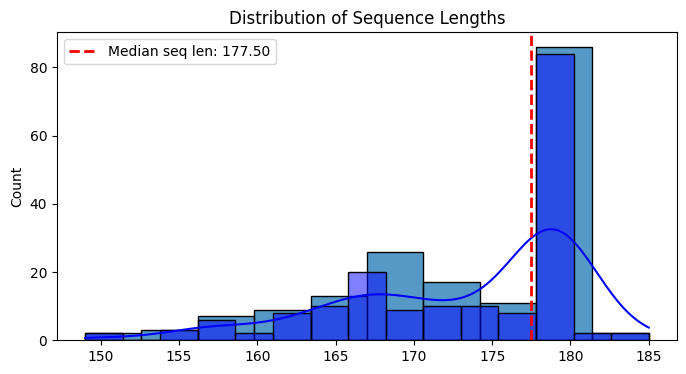

In [7]:
eda_obj.seq_lens_distrib()

### 2. Interactively explore each time-series variable and decompose it into trends, seasonality and residuals

In [8]:
# Create dropdown widget
dropdown = widgets.Dropdown(
    options= config['ts_cols'],
    value="SPARGE_O2",
    description="Select Column:",
    style={'description_width': 'initial'})

# Use interact to link dropdown and plotting function
interact(eda_obj.plot_ts_data, column=dropdown)

interactive(children=(Dropdown(description='Select Column:', index=17, options=('AGIT', 'AGIT_SEAL_PRESS', 'DO…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## Look at correlations

### 1. Bi-variate correlations

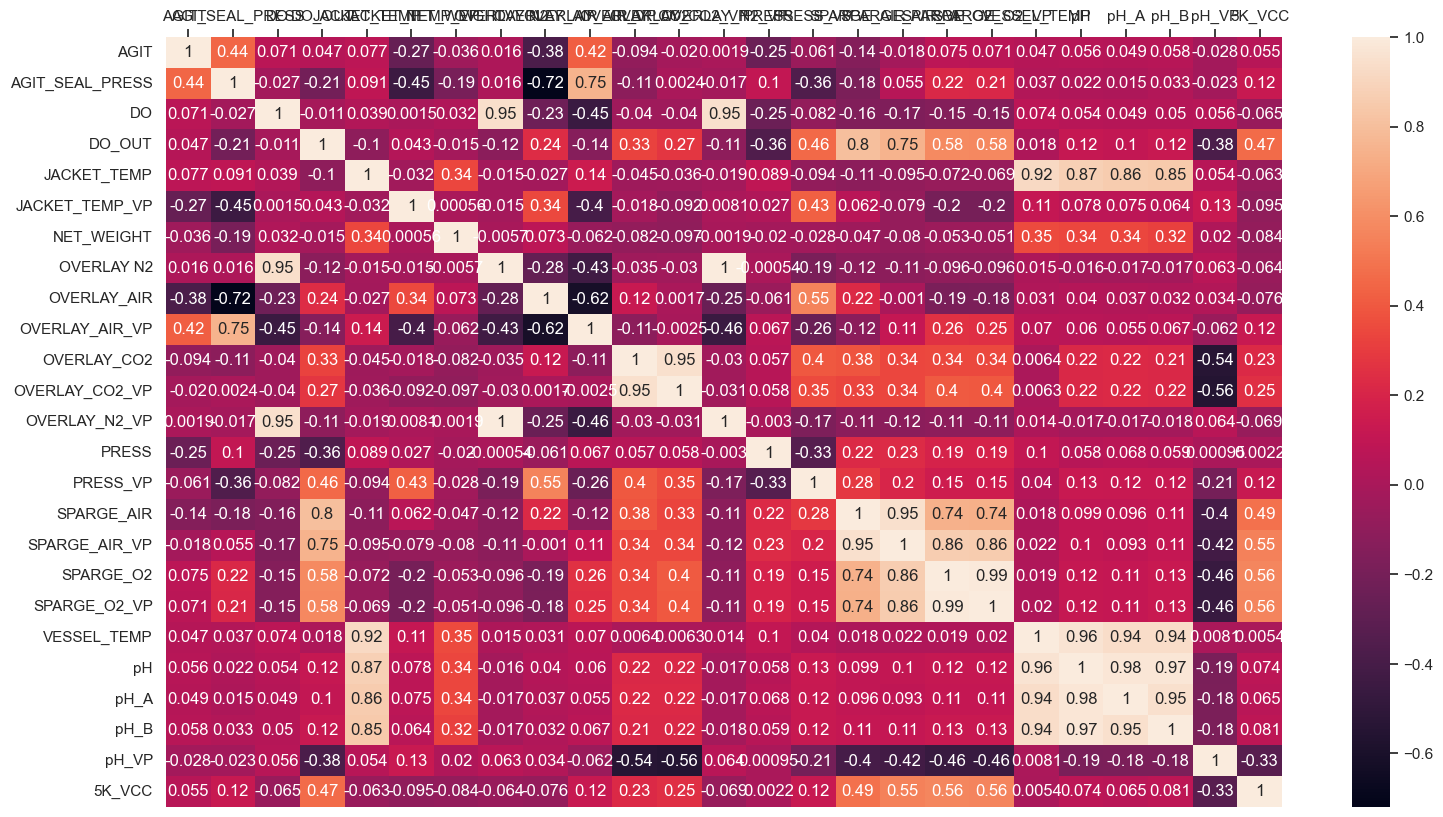

In [9]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(mv_ts[config['ts_cols']].corr(), annot=True)
ax.xaxis.tick_top()

### 2. Correlation between the target variable and some meta-data variable

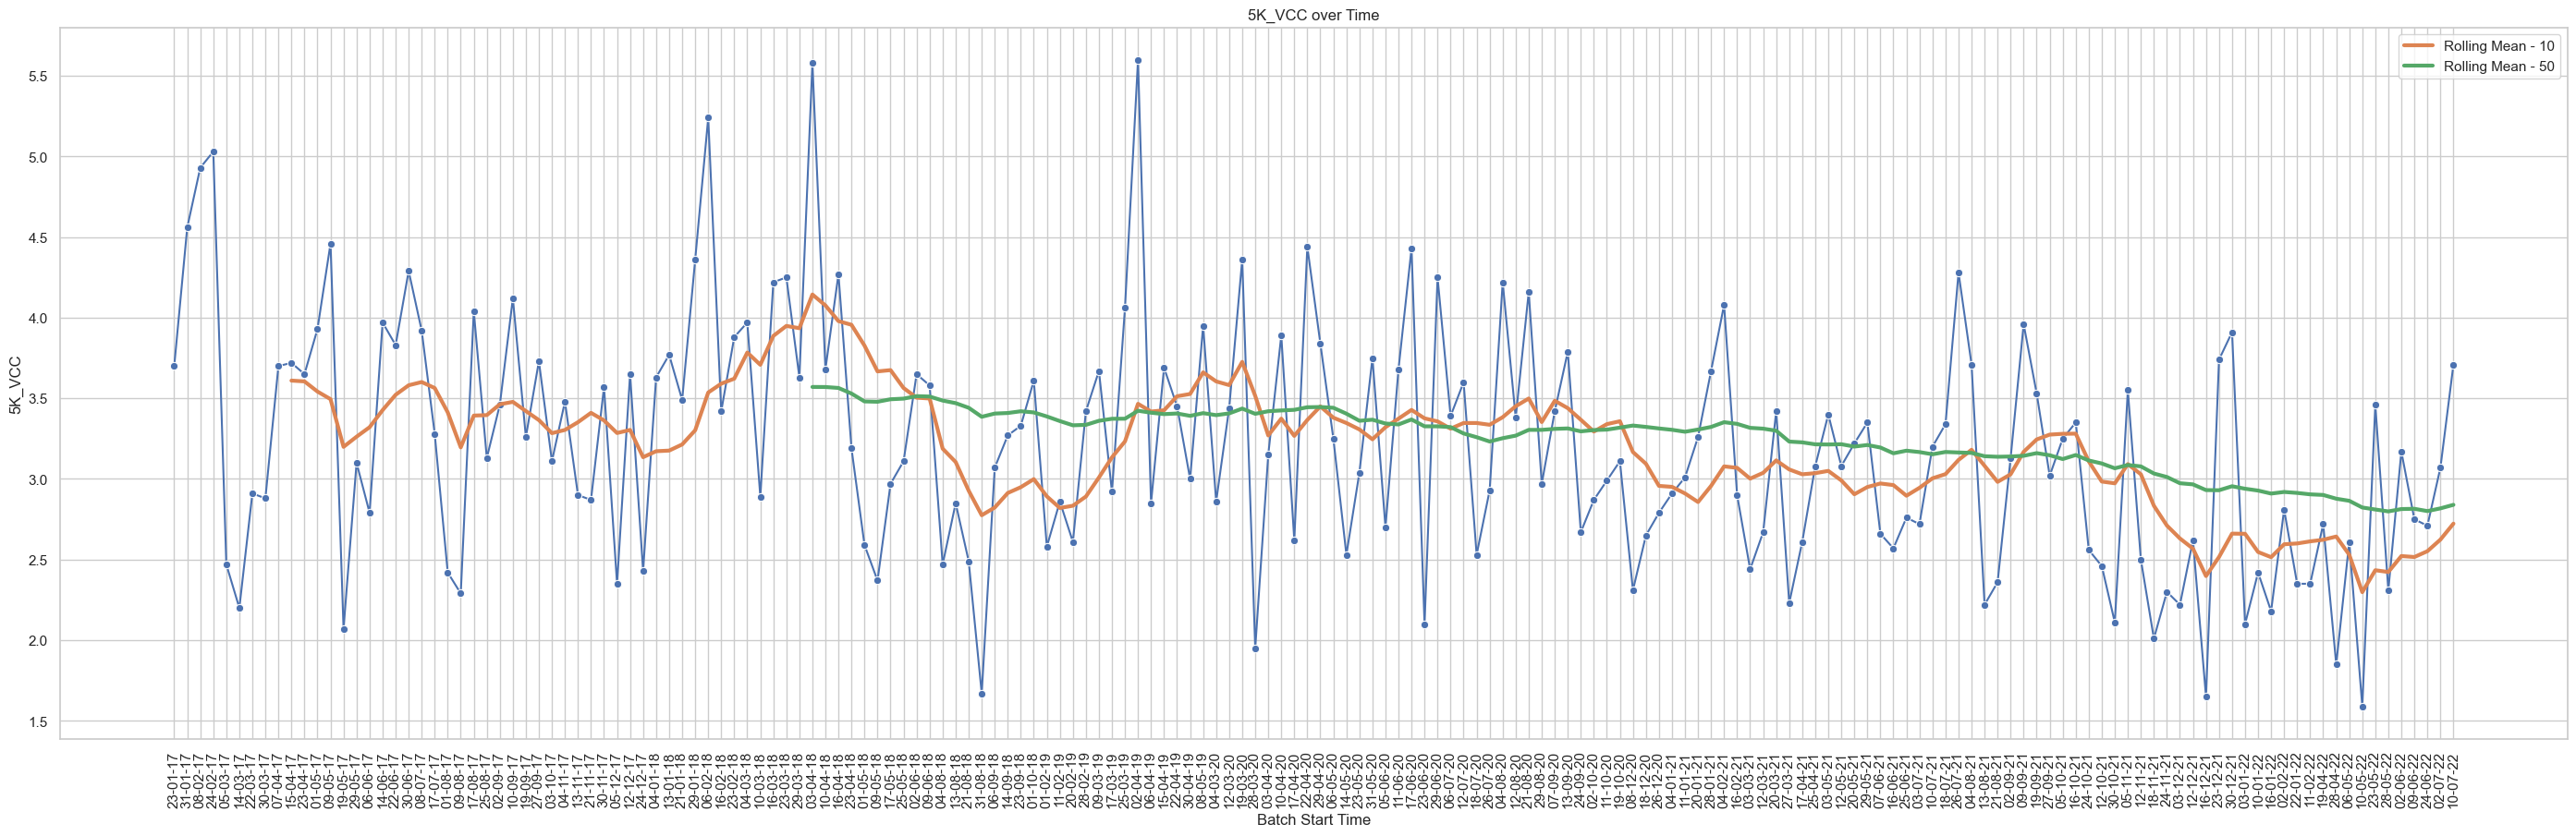

In [10]:
merged_df = eda_obj.batch_start_time_corr_with_yield()

<Axes: >

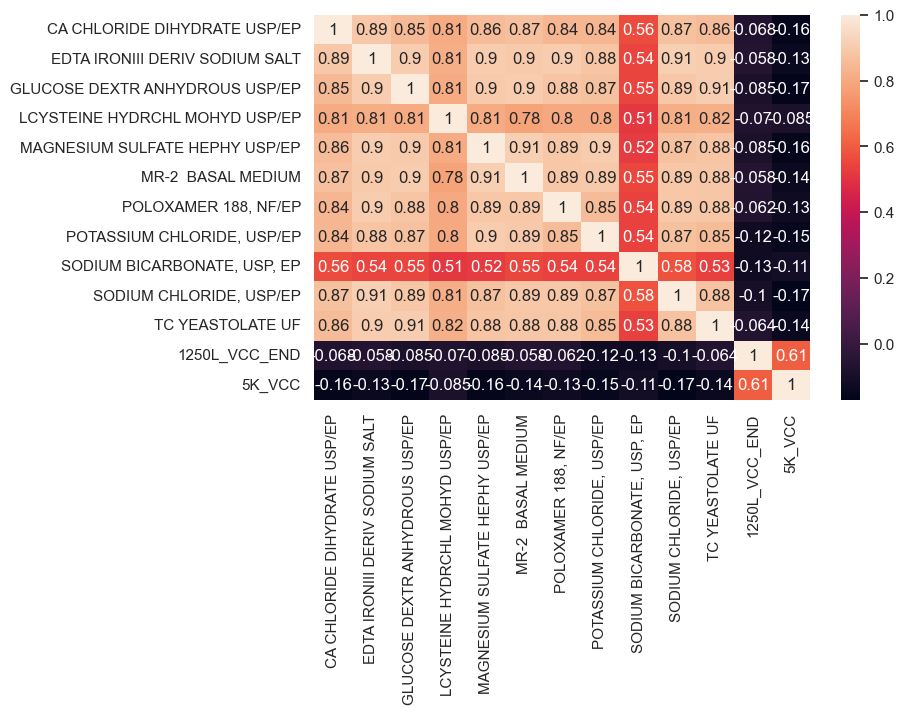

In [11]:
corr_cols = [c for c in eda_obj.merged_df.columns if c not in [config['seq_identifier_col'], 'START_TIME']]

plt.figure(figsize=(8, 5))
sns.heatmap(eda_obj.merged_df[corr_cols].corr(), annot=True)

## Check Auto-Correlation Factor (ACF) and PACF

In [26]:
# Create dropdown widget
dropdown = widgets.Dropdown(
    options= config['ts_cols'],
    value="SPARGE_O2",
    description="Select Column:",
    style={'description_width': 'initial'})

# Use interact to link dropdown and plotting function
interact(eda_obj.plot_acf_pacf, column=dropdown)

interactive(children=(Dropdown(description='Select Column:', index=17, options=('AGIT', 'AGIT_SEAL_PRESS', 'DO…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [12]:
# sns.pairplot(eda_obj.mv_ts[config['ts_cols'][:7]], corner=True)

## Cluster similar time-series (based on meta data)

{'seq_data_path': 'data/batch_data_5K_120_seq_v2.csv', 'static_data_path': 'data/batch_data_5K_static_v2.csv', 'seq_identifier_col': 'BATCH_ID', 'time_step_col': 'TIME_STEP', 'cols_to_drop': 'PROCESS', 'ts_cols': ['AGIT', 'AGIT_SEAL_PRESS', 'DO', 'DO_OUT', 'JACKET_TEMP', 'JACKET_TEMP_VP', 'NET_WEIGHT', 'OVERLAY N2', 'OVERLAY_AIR', 'OVERLAY_AIR_VP', 'OVERLAY_CO2', 'OVERLAY_CO2_VP', 'OVERLAY_N2_VP', 'PRESS', 'PRESS_VP', 'SPARGE_AIR', 'SPARGE_AIR_VP', 'SPARGE_O2', 'SPARGE_O2_VP', 'VESSEL_TEMP', 'pH', 'pH_A', 'pH_B', 'pH_VP', '5K_VCC']}


c:\Users\SC26218\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\SC26218\Desktop\practice\multivariate_timeseries_cheatsheet\ts_clustering.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.meta_data['Cluster'] = clusters


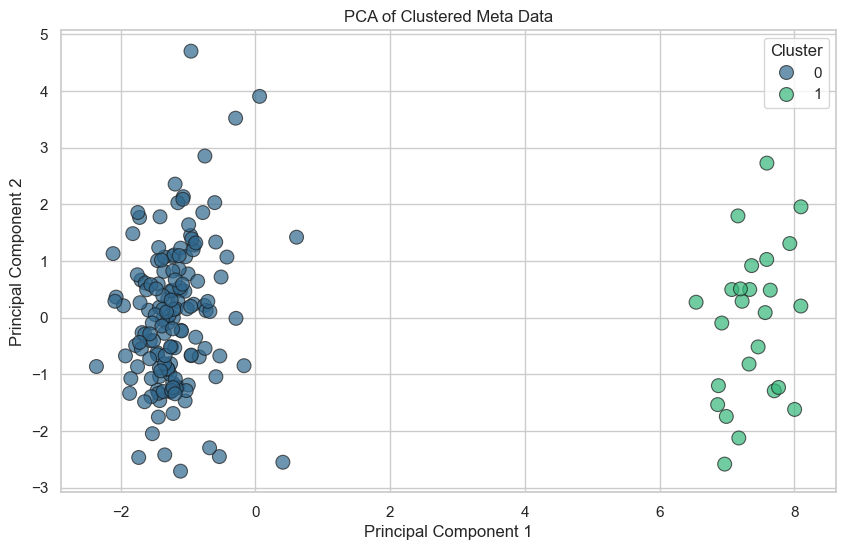

In [13]:
cluster_obj = Multivariate_TS_Clustering(config, eda_obj.mv_ts, eda_obj.merged_df[corr_cols])
meta_data_clustered, kmeans_model = cluster_obj.KMeans_cluster_meta_data(n_clusters=2)
cluster_obj.perform_pca_and_plot(n_components=2)

>> Cluster 0 avg yield =  3.16,   Median yield =  3.11 
>> Cluster 1 avg yield =  3.49,   Median yield =  3.70 





<Figure size 2000x1000 with 0 Axes>

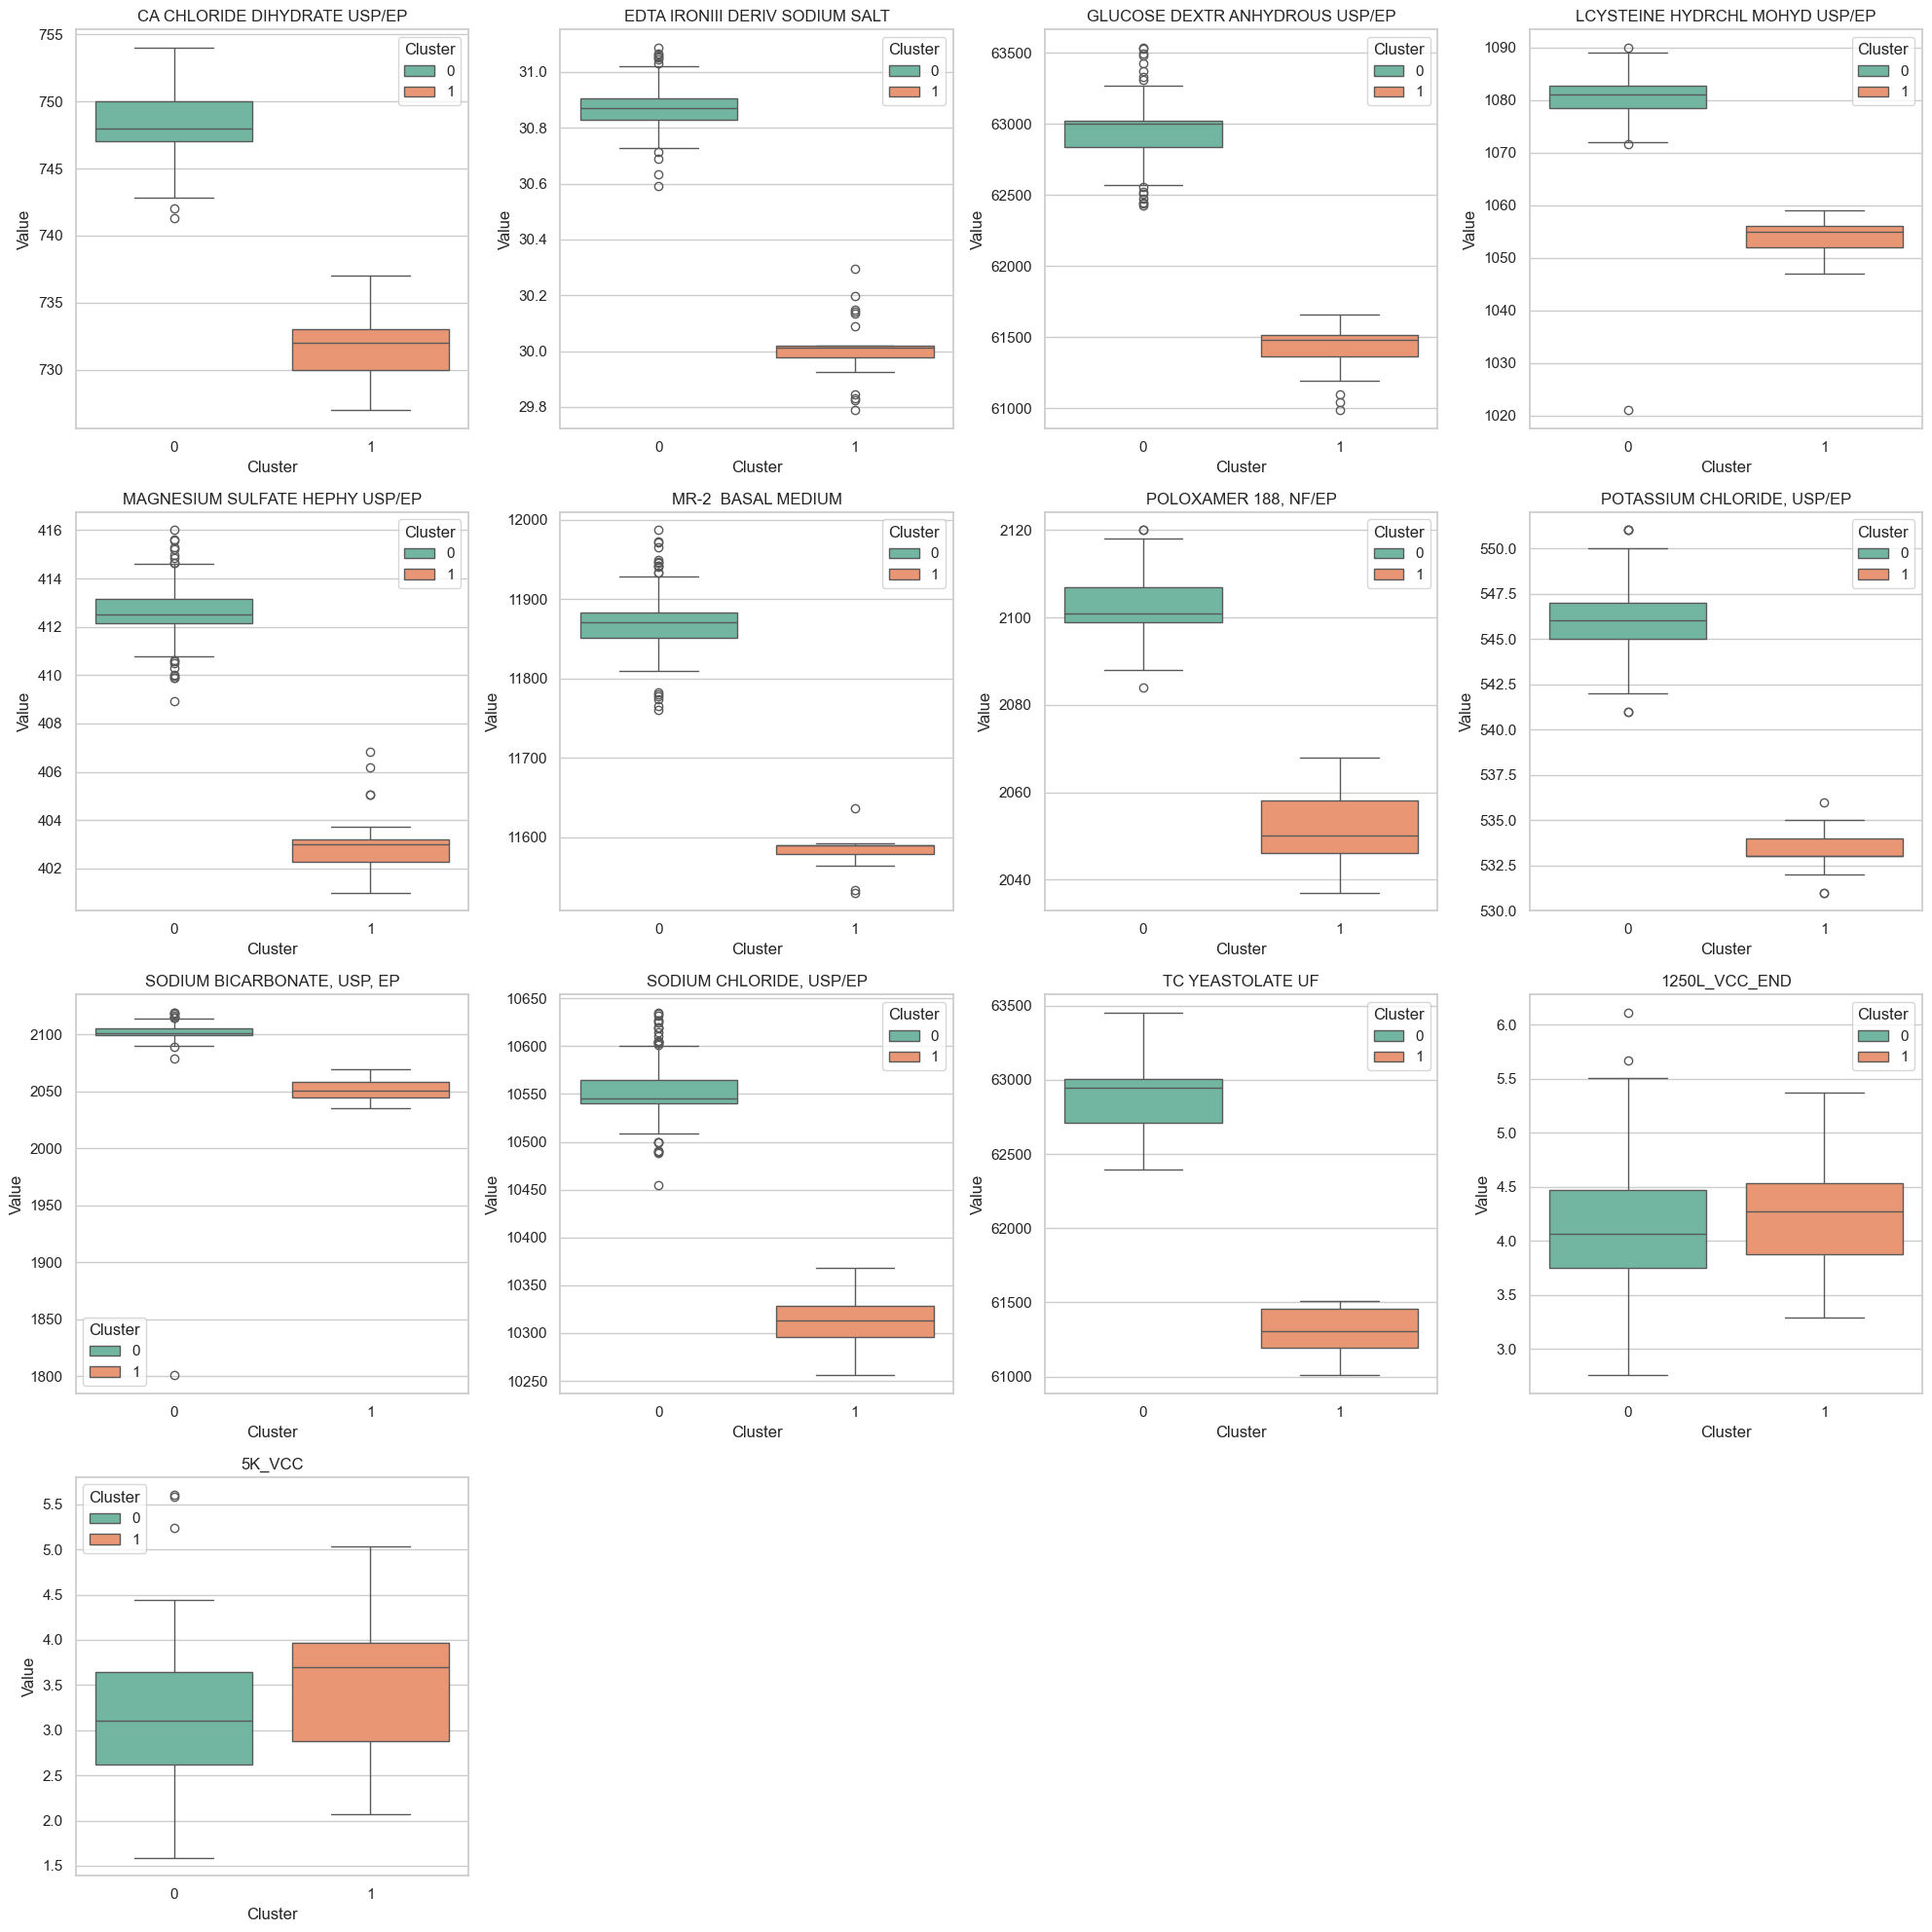

In [14]:
print(f">> Cluster 0 avg yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 0]['5K_VCC'].mean() : .2f},   Median yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 0]['5K_VCC'].median() : .2f} ")
print(f">> Cluster 1 avg yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 1]['5K_VCC'].mean() : .2f},   Median yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 1]['5K_VCC'].median() : .2f} ")
print("\n\n")
cluster_obj.visualize_cluster_differences()

In [15]:
eda_obj.meta_data['Cluster'] = cluster_obj.meta_data['Cluster'].astype(str)

### 3. See how clusters are assigned to batches over time

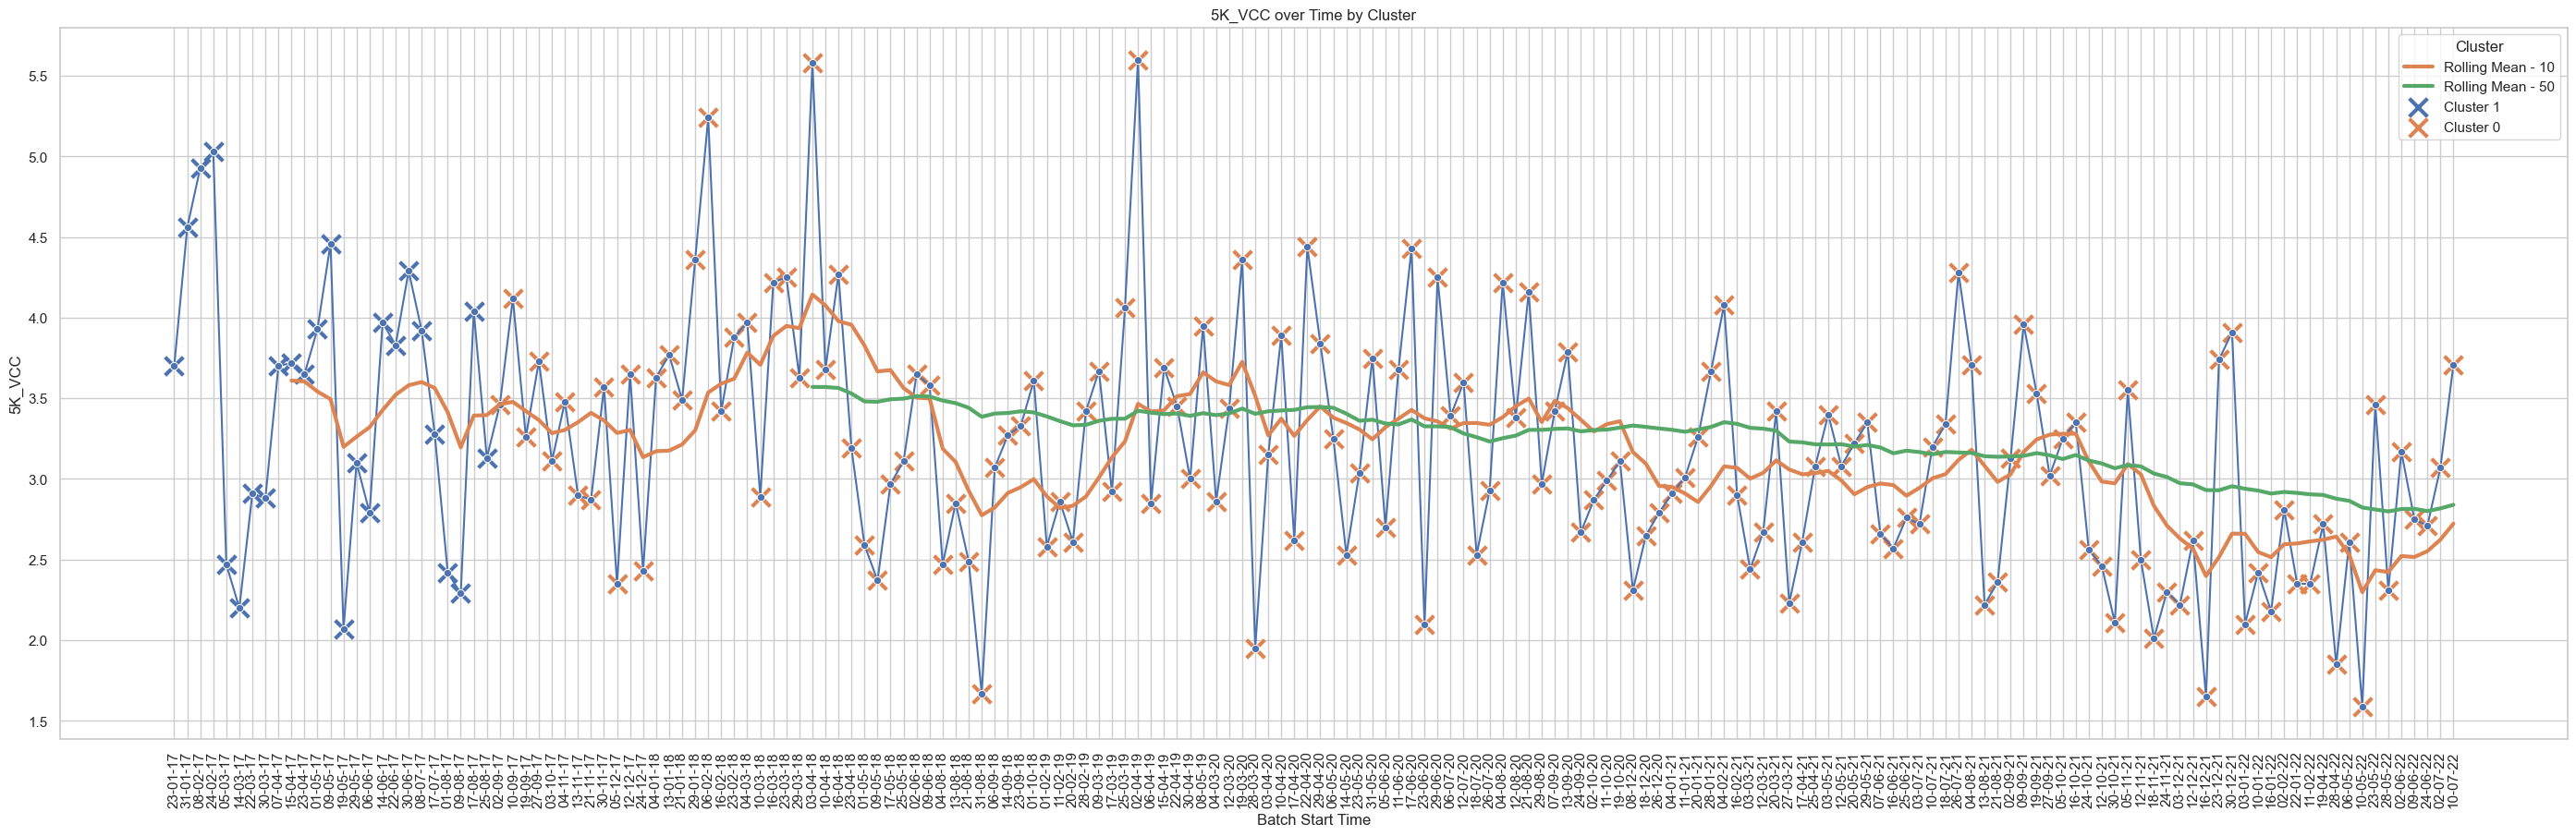

In [16]:
eda_obj.batch_start_time_corr_with_yield(cluster_plots=True)

## Cluster similar time-series (based on time-series data)

### 1. First, visualize the multi-variate TS data as an image to look at visible patterns and trends

In [17]:
# Create dropdown widget
dropdown = widgets.Dropdown(
    options= eda_obj.mv_ts[config['seq_identifier_col']].unique(),
    value="J0417001",
    description="Select Batch to visualize:",
    style={'description_width': 'initial'})


# Use interact to link dropdown and plotting function
interact(cluster_obj.plot_multivariate_ts_as_image, selected_batch_id=dropdown)




interactive(children=(Dropdown(description='Select Batch to visualize:', options=('J0417001', 'J0417002', 'J04…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### 2. Apply a CNN-based Auto-encoder to obtain latent embeddings of each sequence.

In [19]:
# Hyperparameters
config['input_channels'] = 1 # len(config['ts_cols'])
config['learning_rate'] = 0.001
config['num_epochs'] = 2000
config['batch_size'] = 32
config['model_save_path'] = "./model_checkpoints/test.pt"

cluster_obj.prepare_data()
cluster_obj.prepare_model_and_optmzr()

--------------------------------------------------
Preparing data for training the CNN Autoencoder
--------------------------------------------------
>> Max len seq for padding the rest =  185
>> The 3D tensor constructed (num_seqs, num_cols, max_time_steps) =  torch.Size([176, 25, 185])
>> Data prepared for training the CNN Autoencoder

--------------------------------------------------
Initializing models and optimizers for training the CNN Autoencoder
--------------------------------------------------
>> Model architecture: 
 CNNAutoencoder(
  (cnnencoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (cnndecoder): CNNDecoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(

Epoch 1, Loss: 923189.8958
>> Current best model at epoch 0 and loss  923189.8958
Epoch 21, Loss: 4573.1257
Epoch 41, Loss: 2017.7618
Epoch 61, Loss: 1162.0665
Epoch 81, Loss: 825.6154
Epoch 101, Loss: 583.4388
>> Current best model at epoch 100 and loss  583.4388
Epoch 121, Loss: 391.7081
Epoch 141, Loss: 281.4719
Epoch 161, Loss: 227.1406
Epoch 181, Loss: 218.1837
Epoch 201, Loss: 176.1986
>> Current best model at epoch 196 and loss  174.4739
Epoch 221, Loss: 164.7449
Epoch 241, Loss: 150.8032
Epoch 261, Loss: 148.2310
Epoch 281, Loss: 140.5404
Epoch 301, Loss: 117.7969
>> Current best model at epoch 300 and loss  117.7969
Epoch 321, Loss: 107.7425
Epoch 341, Loss: 103.8591
Epoch 361, Loss: 89.5763
Epoch 381, Loss: 75.0123
Epoch 401, Loss: 71.0749
>> Current best model at epoch 391 and loss  67.9945
Epoch 421, Loss: 64.1987
Epoch 441, Loss: 54.1401
Epoch 461, Loss: 53.9100
Epoch 481, Loss: 49.6578
Epoch 501, Loss: 83.1626
>> Current best model at epoch 476 and loss  47.5169
Epoch 521

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



>> Final Epoch, Loss: 12.6054


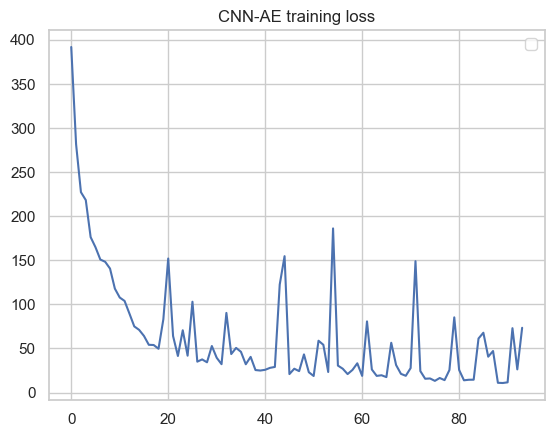

In [20]:
outputs = cluster_obj.train_CNN_AE()